# Навчання агентів для Дилеми в'язня використовуючи Proximal Policy Optimization (PPO)

Цей ноутбук демонструє використання алгоритму глибокого підкріплювального навчання PPO для навчання агента стратегії в Ітерованій Дилемі В'язня (Iterated Prisoner's Dilemma, IPD).

## Що ми будемо робити:
1. Налаштуємо середовище IPD
2. Навчимо PPO-агента проти стратегії Tit-for-Tat
3. Оцінимо продуктивність агента проти різних класичних стратегій
4. Проаналізуємо навчену стратегію та її ефективність

## Очікувані результати:
- Порівняння ефективності різних стратегій
- Розуміння того, як PPO може навчитися кооперативної або конкурентної поведінки
- Візуалізація процесу навчання та результатів

## Імпорт необхідних бібліотек

In [12]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from IPython.display import display
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

# Додаємо шлях до кореневої директорії проекту для можливості імпорту
sys.path.append(os.path.abspath('..'))

# Імпортуємо наше середовище IPD та стратегії
from env import IPDEnv, TitForTat, AlwaysCooperate, AlwaysDefect, RandomStrategy, PavlovStrategy
from agents.ppo.train_ppo import create_env, get_cooperation_rates

# Налаштування стилю візуалізації
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## Налаштування параметрів

In [13]:
# Параметри для створення середовища та навчання
NUM_ROUNDS = 10  # Кількість раундів у грі
MEMORY_SIZE = 3  # Розмір історії (скільки попередніх ходів пам'ятає агент)
SEED = 42       # Початкове значення для відтворюваності результатів

# Шляхи для збереження моделі та результатів
MODEL_DIR = "../models"
RESULTS_DIR = "../results"

# Створюємо директорії, якщо вони не існують
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/ppo", exist_ok=True)

## Створення та налаштування середовища

In [14]:
# Створюємо середовище з стратегією Tit-for-Tat як опонентом
env = create_env(
    opponent_strategy="tit_for_tat",
    num_rounds=NUM_ROUNDS,
    memory_size=MEMORY_SIZE,
    seed=SEED
)

# Створюємо окреме середовище для оцінки
eval_env = create_env(
    opponent_strategy="tit_for_tat",
    num_rounds=NUM_ROUNDS,
    memory_size=MEMORY_SIZE,
    seed=SEED+100  # Інший seed для оцінки
)

# Виводимо інформацію про середовище
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Number of rounds per game: {NUM_ROUNDS}")
print(f"Memory size: {MEMORY_SIZE}")
print(f"Opponent strategy: {env.env.opponent_strategy.name}")

Observation space: Box(-1, 1, (6,), int8)
Action space: Discrete(2)
Number of rounds per game: 10
Memory size: 3
Opponent strategy: Tit-for-Tat


## Навчання PPO-агента

Тепер ми використаємо алгоритм PPO (Proximal Policy Optimization) з бібліотеки stable-baselines3 для навчання агента. 

PPO - це алгоритм підкріплювального навчання, який оптимізує стратегію (policy) агента ітеративно, обмежуючи розмір оновлення параметрів між ітераціями для забезпечення стабільності.

In [15]:
# Параметри для навчання PPO
learning_rate = 3e-4
n_steps = 2048      # Кількість кроків перед кожним оновленням
batch_size = 64     # Розмір міні-пакету
n_epochs = 10       # Кількість ітерацій навчання на кожному пакеті даних
gamma = 0.99        # Коефіцієнт знецінення
ent_coef = 0.01     # Коефіцієнт ентропії для заохочення дослідження
total_timesteps = 100000  # Зменшено для демонстрації, звичайно використовується 200000-500000

# Ініціалізуємо модель PPO
model = PPO(
    "MlpPolicy",
    env,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    gamma=gamma,
    ent_coef=ent_coef,
    n_epochs=n_epochs,
    verbose=1,
    tensorboard_log=f"{RESULTS_DIR}/ppo_tensorboard",
    seed=SEED
)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [16]:
# Навчання моделі
# Примітка: це може зайняти кілька хвилин
start_time = time.time()
model.learn(total_timesteps=total_timesteps)
training_time = time.time() - start_time

print(f"Навчання завершено за {training_time:.2f} секунд")

# Зберігаємо навчену модель
model_path = f"{MODEL_DIR}/ppo_demo.zip"
model.save(model_path)
print(f"Модель збережено у {model_path}")

Logging to ../results/ppo_tensorboard/PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 24.4     |
| time/              |          |
|    fps             | 5281     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 25.5        |
| time/                   |             |
|    fps                  | 3217        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010158229 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 

## Оцінка навченого агента проти різних опонентів

Тепер оцінимо, наскільки добре наш агент грає проти різних класичних стратегій.

In [17]:
# Оцінимо модель проти стратегії Tit-for-Tat
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50, deterministic=True)
print(f"Середня винагорода проти Tit-for-Tat: {mean_reward:.2f} ± {std_reward:.2f}")

# Отримуємо рівень кооперації
cooperation_rates = get_cooperation_rates(model, eval_env, n_episodes=50)
print(f"Рівень кооперації агента: {cooperation_rates['agent']:.2f}")
print(f"Рівень кооперації опонента: {cooperation_rates['opponent']:.2f}")

Середня винагорода проти Tit-for-Tat: 30.00 ± 0.00
Рівень кооперації агента: 1.00
Рівень кооперації опонента: 1.00


In [18]:
# Тепер оцінимо агента проти різних опонентів
opponent_strategies = {
    "tit_for_tat": TitForTat(),
    "always_cooperate": AlwaysCooperate(),
    "always_defect": AlwaysDefect(),
    "random": RandomStrategy(seed=SEED+200),
    "pavlov": PavlovStrategy()
}

# Проводимо оцінку
results = []

for opponent_name, opponent_strategy in opponent_strategies.items():
    # Створюємо середовище з поточним опонентом
    env = create_env(
        opponent_strategy=opponent_strategy,
        num_rounds=NUM_ROUNDS,
        memory_size=MEMORY_SIZE,
        seed=SEED+300
    )
    
    # Оцінюємо модель
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50, deterministic=True)
    
    # Отримуємо рівні кооперації
    cooperation_rates = get_cooperation_rates(model, env, n_episodes=50)
    
    # Зберігаємо результати
    results.append({
        "opponent": opponent_name,
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "agent_cooperation_rate": cooperation_rates["agent"],
        "opponent_cooperation_rate": cooperation_rates["opponent"]
    })

# Створюємо DataFrame з результатами
results_df = pd.DataFrame(results)
display(results_df)

,opponent,mean_reward,std_reward,agent_cooperation_rate,opponent_cooperation_rate
0,tit_for_tat,30.0,0.000000,1.0,1.000
1,always_cooperate,30.0,0.000000,1.0,1.000
2,always_defect,0.0,0.000000,1.0,0.000
3,random,14.4,4.947727,1.0,0.508
4,pavlov,30.0,0.000000,1.0,1.000


## Візуалізація результатів

/var/folders/80/slqg73_x62s055tz5zmhx1b40000gn/T/ipykernel_5789/459893774.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="opponent", y="mean_reward", data=results_df, palette="viridis")


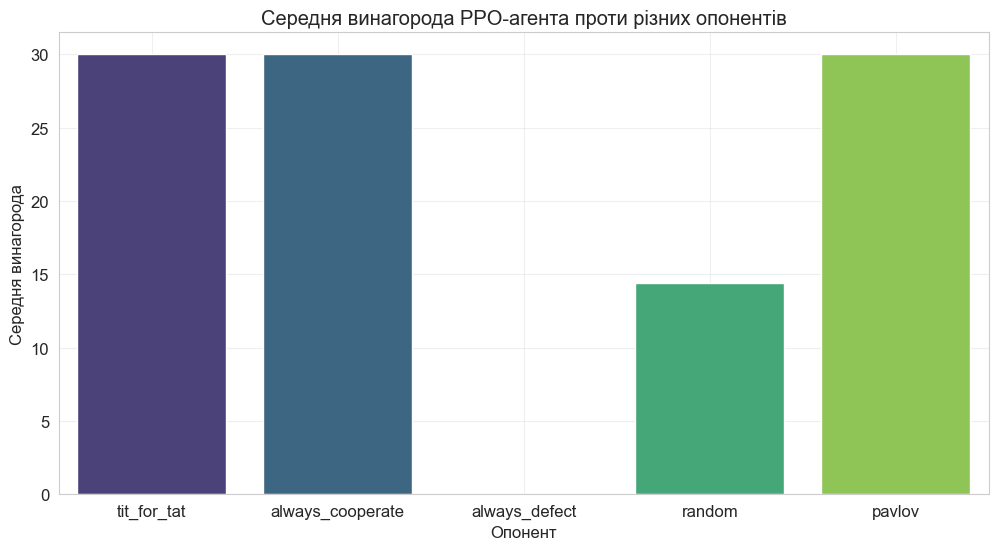

In [19]:
# Візуалізуємо середню винагороду для різних опонентів
plt.figure(figsize=(12, 6))
sns.barplot(x="opponent", y="mean_reward", data=results_df, palette="viridis")
plt.title("Середня винагорода PPO-агента проти різних опонентів")
plt.xlabel("Опонент")
plt.ylabel("Середня винагорода")
plt.grid(True, alpha=0.3)
plt.show()

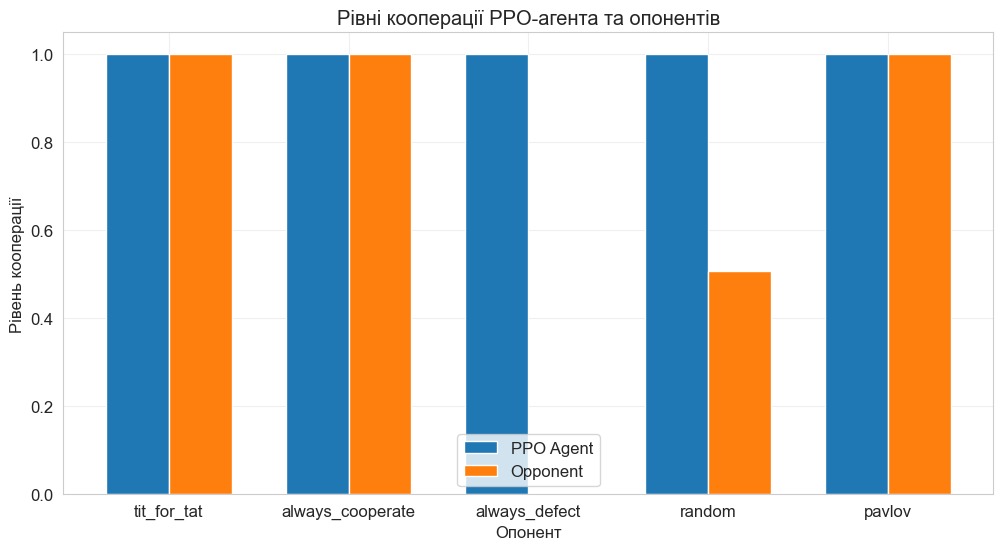

In [20]:
# Візуалізуємо рівні кооперації
plt.figure(figsize=(12, 6))

# Підготовка даних для групового стовпчикового графіка
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df["agent_cooperation_rate"], width, label="PPO Agent")
plt.bar(x + width/2, results_df["opponent_cooperation_rate"], width, label="Opponent")

plt.title("Рівні кооперації PPO-агента та опонентів")
plt.xlabel("Опонент")
plt.ylabel("Рівень кооперації")
plt.xticks(x, results_df["opponent"])
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Перегляд ходу окремої гри

Подивимося на один конкретний матч між PPO-агентом та стратегією Tit-for-Tat.

In [21]:
# Створюємо середовище для демонстрації
demo_env = create_env(
    opponent_strategy="tit_for_tat",
    num_rounds=NUM_ROUNDS,
    memory_size=MEMORY_SIZE,
    seed=SEED
)

# Скидаємо середовище
observation, _ = demo_env.reset()
done = False
total_reward = 0
game_history = []

# Проходимо одну гру
while not done:
    # Отримуємо дію від агента
    action, _ = model.predict(observation, deterministic=True)
    
    # Виконуємо крок у середовищі
    observation, reward, terminated, truncated, info = demo_env.step(action)
    done = terminated or truncated
    
    # Зберігаємо інформацію
    total_reward += reward
    game_history.append(info)

# Виводимо інформацію про гру
print(f"Загальна винагорода: {total_reward}")
print(f"Рахунок: Агент {demo_env.env.player_score} - {demo_env.env.opponent_score} Опонент")

# Створюємо DataFrame для візуалізації історії гри
history_df = pd.DataFrame(game_history)
history_df["action_name"] = history_df["player_action"].apply(lambda x: "Cooperate" if x == 0 else "Defect")
history_df["opponent_action_name"] = history_df["opponent_action"].apply(lambda x: "Cooperate" if x == 0 else "Defect")
display(history_df[["round", "action_name", "opponent_action_name", "player_payoff", "opponent_payoff"]])

Загальна винагорода: 30
Рахунок: Агент 30 - 30 Опонент


,round,action_name,opponent_action_name,player_payoff,opponent_payoff
0,1,Cooperate,Cooperate,3,3
1,2,Cooperate,Cooperate,3,3
2,3,Cooperate,Cooperate,3,3
3,4,Cooperate,Cooperate,3,3
4,5,Cooperate,Cooperate,3,3
5,6,Cooperate,Cooperate,3,3
6,7,Cooperate,Cooperate,3,3
7,8,Cooperate,Cooperate,3,3
8,9,Cooperate,Cooperate,3,3
9,10,Cooperate,Cooperate,3,3


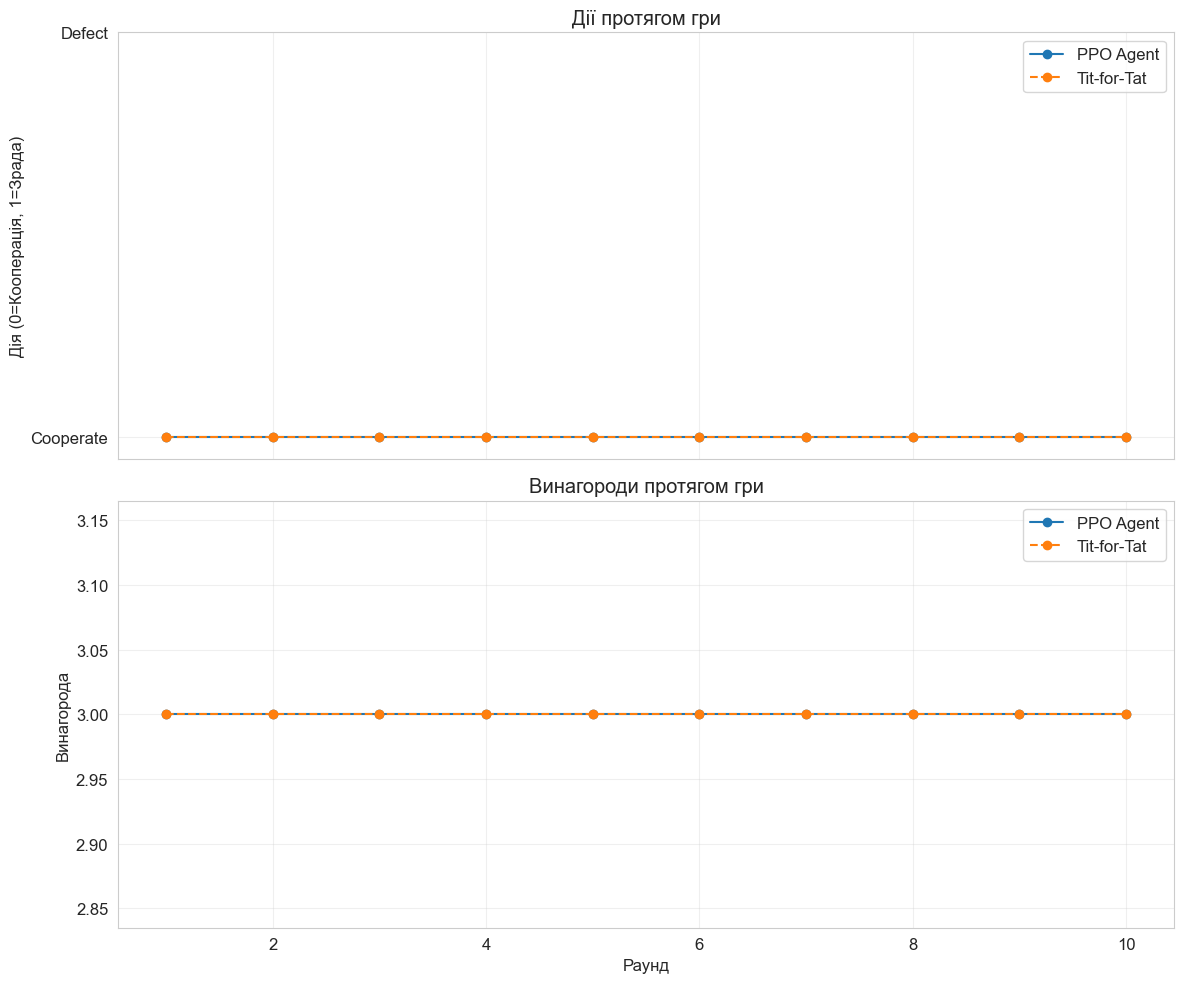

In [22]:
# Візуалізуємо кооперацію та винагороди протягом гри
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Графік дій (кооперація/зрада)
ax1.plot(history_df["round"], history_df["player_action"], 'o-', label="PPO Agent")
ax1.plot(history_df["round"], history_df["opponent_action"], 'o--', label="Tit-for-Tat")
ax1.set_ylabel("Дія (0=Кооперація, 1=Зрада)")
ax1.set_title("Дії протягом гри")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(["Cooperate", "Defect"])

# Графік винагород
ax2.plot(history_df["round"], history_df["player_payoff"], 'o-', label="PPO Agent")
ax2.plot(history_df["round"], history_df["opponent_payoff"], 'o--', label="Tit-for-Tat")
ax2.set_xlabel("Раунд")
ax2.set_ylabel("Винагорода")
ax2.set_title("Винагороди протягом гри")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Висновки

Ми успішно навчили PPO-агента грати в Ітеровану Дилему В'язня. Основні спостереження:

1. PPO може навчитися ефективній стратегії для гри з різними опонентами
2. Агент може адаптувати свою поведінку залежно від опонента, з яким він взаємодіє
3. Рівень кооперації агента залежить від того, проти якого опонента він був навчений

Для поліпшення результатів можна спробувати:
- Тренувати проти різних опонентів або міксу стратегій
- Збільшити кількість раундів у грі
- Експериментувати з параметрами PPO
- Змінити структуру винагороди для заохочення певних типів поведінки

PPO є потужним алгоритмом для вирішення задач Дилеми В'язня, особливо коли потрібна адаптивна стратегія, яка може змінюватись залежно від поведінки опонента.